# Clustering con k-Means

---



Comenzamos importando librerias tradicionales:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 
import numpy as np

## Introducing k-Means

El algoritmo *k*-means busca un número predeterminado de clústeres dentro de un conjunto de datos multidimensionales sin etiquetar.
Lo logra utilizando una concepción simple de cómo se ve la agrupación óptima:

- El "centro del grupo" es la media aritmética de todos los puntos que pertenecen al grupo.
- Cada punto está más cerca de su propio centro de grupo que de otros centros de grupo.

Esos dos supuestos son la base del modelo de *k*-means.
Pronto nos sumergiremos en exactamente *cómo* el algoritmo llega a esta solución, pero por ahora echemos un vistazo a un conjunto de datos simple y veamos el resultado de *k*-means.

Primero, generemos un conjunto de datos bidimensional que contenga cuatro blobs distintos.
Para enfatizar que este es un algoritmo no supervisado, dejaremos las etiquetas fuera de la visualización.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


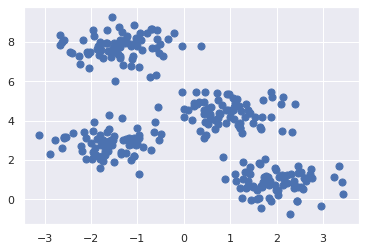

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

A simple vista, es relativamente fácil distinguir los cuatro grupos.
El algoritmo *k*-means hace esto automáticamente, y en Scikit-Learn usa la API de estimador típica:

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Visualicemos los resultados trazando los datos coloreados por estas etiquetas.

También trazaremos los centros de los conglomerados determinados por el estimador de *k*-means:

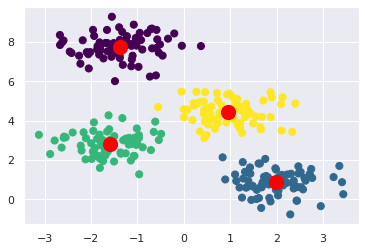

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=1);

La buena noticia es que el algoritmo *k*-means (al menos en este caso simple) asigna los puntos a los grupos de manera muy similar a como podríamos asignarlos a simple vista.
¡Pero quizás se pregunte cómo este algoritmo encuentra estos grupos tan rápidamente! Después de todo, el número de posibles combinaciones de asignaciones de conglomerados es exponencial en el número de puntos de datos; una búsqueda exhaustiva sería muy, muy costosa.
Afortunadamente para nosotros, una búsqueda tan exhaustiva no es necesaria: en cambio, el enfoque típico de *k*-means implica un enfoque iterativo intuitivo conocido como *expectativa-maximización*.

## k-Means: Expectativa–Maximización

La maximización de expectativas (E – M) es un poderoso algoritmo que surge en una variedad de contextos dentro de la ciencia de datos.
*k*-means es una aplicación del algoritmo particularmente simple y fácil de entender, y la veremos brevemente aquí.
En resumen, el enfoque de maximización de expectativas consiste en el siguiente procedimiento:

1. Adivina algunos centros de clústeres
2. Repita hasta converger
   1. *E-Step*: asigna puntos al centro del grupo más cercano
   2. *Paso M*: establezca los centros de los conglomerados en la media

Aquí, el "paso E" o "paso de expectativa" se llama así porque implica actualizar nuestra expectativa de a qué grupo pertenece cada punto.
El "paso M" o "paso de maximización" se llama así porque implica maximizar alguna función de aptitud que define la ubicación de los centros del grupo; en este caso, la maximización se logra tomando una media simple de los datos en cada grupo .

La literatura sobre este algoritmo es vasta, pero se puede resumir de la siguiente manera: en circunstancias típicas, cada repetición del paso E y del paso M siempre dará como resultado una mejor estimación de las características del conglomerado.

Podemos visualizar el algoritmo como se muestra en la siguiente figura.
Para la inicialización particular que se muestra aquí, los clústeres convergen en solo tres iteraciones.

![(run code in Appendix to generate image)](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.11-expectation-maximization.png?raw=1)


El algoritmo *k*-Means es tan simple que podemos escribirlo en unas pocas líneas de código.

La siguiente es una implementación muy básica:

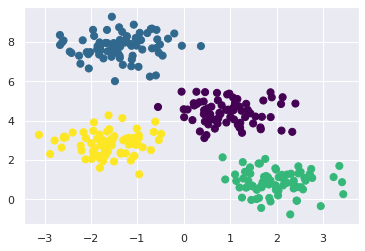

In [6]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Escoger clusters al azar
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Asignemos etiquetas en base al centroide más cercano
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Recalcular la medida de distancia media con los nuevos puntos
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Verificar si converge el algoritmo
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

La mayoría de las implementaciones bien probadas harán un poco más que esto detrás de cámaras, pero la función anterior da la esencia del enfoque de maximización de expectativas.

### Ejemplo: k-means con MNIST

Aquí intentaremos usar * k * -medios para intentar identificar dígitos similares * sin usar la información de la etiqueta original *; esto podría ser similar a un primer paso para extraer el significado de un nuevo conjunto de datos sobre el que no tiene ninguna información de etiqueta * a priori *.

Comenzaremos cargando los dígitos y luego encontrando los grupos de ``KMeans``.
Recuerde que los dígitos consisten en 1,797 muestras con 64 características, donde cada una de las 64 características es el brillo de un píxel en una imagen de 8 × 8:

In [7]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Creemos 20 modelos K-Means y midamos las distancias de los centroides. Utiizaremos las distancias para graficar un "Elbow Plot" y escoger el número óptimo de clusters

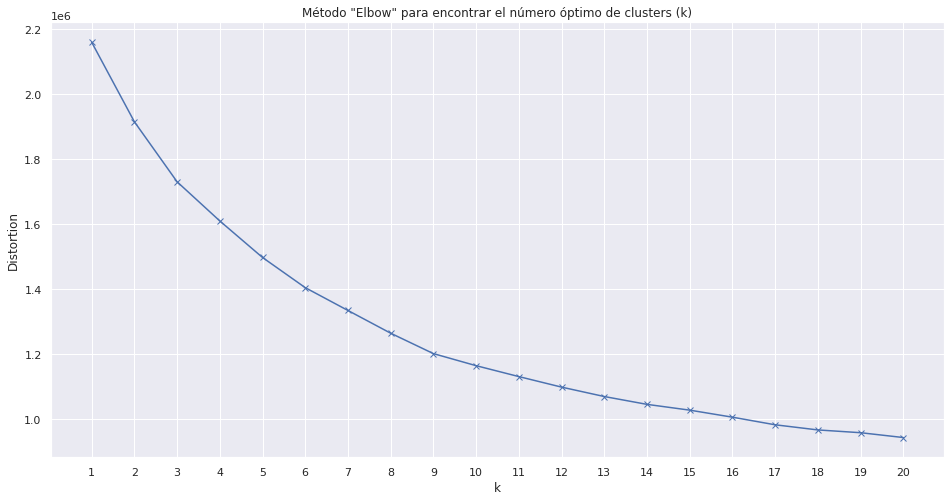

In [8]:
# Iniciemos una lista para guardar las distancias/distorciones
distortions = []

# Entrenemos 20 modelos y guardemos la distancias/distorciones en la lista
K = range(1,21)
for k in K:

    # Instanciamos el modelo
    kmeanModel = KMeans(n_clusters=k)

    # Ajustamos el modelo
    kmeanModel.fit(digits.data)

    # Guardamos las distancias/distorciones
    distortions.append(kmeanModel.inertia_)


# Creamos una gráfica tipo "Elbow"
fig, ax = plt.subplots(figsize=(16,8))

# Graficamos las distancias/distorciones
ax.plot(K, distortions, 'bx-')

# Asignamos valores y títulos de ejes
ax.set_xticks(list(K))
ax.set_xlabel('k')
ax.set_ylabel('Distortion')

# Asignamos título al gráfico
ax.set_title('Método "Elbow" para encontrar el número óptimo de clusters (k)')

plt.show()

EL proceso de clustering es igual al que vimos hace poco. En el gráfico anterior seleccionamos 10 como el número óptimo de clusters.


In [9]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

El resultado son 10 grupos en 64 dimensiones.

Observe que los centros de los grupos en sí mismos son puntos de 64 dimensiones y pueden interpretarse como el dígito "típico" dentro del grupo.
Veamos cómo se ven estos centros de clústeres:

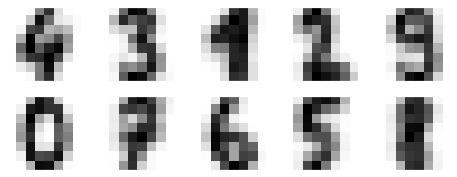

In [10]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [11]:
import pandas as pd
cluster_df = pd.DataFrame({"target": digits.target, "cluster": kmeans.predict(digits.data)})

In [12]:
cluster_df.query("cluster == 3")

,target,cluster
12,2,3
22,2,3
84,2,3
113,2,3
132,2,3
...,...,...
1744,2,3
1751,2,3
1780,2,3
1782,2,3


Vemos que *incluso sin las etiquetas*, ``KMeans`` puede encontrar grupos cuyos centros son dígitos reconocibles, quizás con la excepción del 1 y el 8.

Debido a que *k*- no conoce nada sobre la identidad del clúster, las etiquetas 0–9 pueden variar.

Podemos solucionar este problema haciendo coincidir cada etiqueta de clúster aprendida con las etiquetas verdaderas que se encuentran en ellas:

In [13]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Ahora podemos comprobar qué tan precisa fue nuestra agrupación en clústeres sin supervisión para encontrar dígitos similares dentro de los datos:

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

¡Con un simple algoritmo de *k*-means, descubrimos la agrupación correcta para el 80% de los dígitos de entrada!
Revisemos la matriz de confusión para esto:

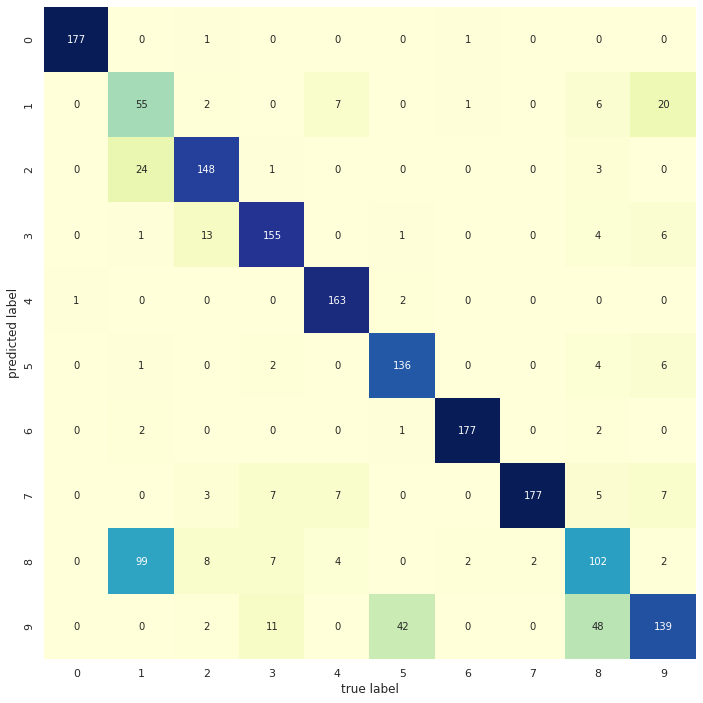

In [15]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,cmap='YlGnBu',
            xticklabels=digits.target_names,
            yticklabels=digits.target_names,
            ax=ax)
ax.set_xlabel('true label')
ax.set_ylabel('predicted label')
plt.show()

Ahora veamos como guardar el modelo en un archivo para voverlo a utilizar


In [17]:
import pickle
import os

# Guardemos el modelo en memoria
filename = 'kmeans.pkl'
pickle.dump(kmeans, open(filename, 'wb'))

# Verifiquemos que está guardado en el directorio de trabajo
print(os.listdir())
 
# Insertemos un espacio
print("\n")
 
# Carguemos el modelo bajo otro nombre y hagamos predicciones
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(digits.data)
print(result)

['.config', 'kmeans.sav', 'kmeans.pkl', 'sample_data']


[5 9 9 ... 9 4 4]


In [18]:
# Verifiquemos que está guardado en el directorio de trabajo
print(os.listdir())

['.config', 'kmeans.sav', 'kmeans.pkl', 'sample_data']


In [19]:
# Carguemos el modelo bajo otro nombre y hagamos predicciones
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(digits.data)
print(result)

[5 9 9 ... 9 4 4]
